## Entrenamiento de un modelo XGBoost

In [1]:
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

airline_df = pd.read_csv('../Data/airline_recoded.csv')

X = airline_df.drop(columns = ['satisfaction'])
y = airline_df['satisfaction']

Entrenamiento del modelo

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

eval_set = [(X_train, y_train), (X_test, y_test)]
model = xgb.XGBClassifier(eval_metric="logloss")

model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

results = model.evals_result()

y_pred = model.predict(X_test)

cv_scores = cross_val_score(model, X, y, cv=5)

print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

Puntajes de validación cruzada: [0.96140705 0.96333189 0.96039652 0.96376498 0.96270452]
Media de los puntajes: 0.962320992296074


Evaluación del modelo con matriz de confusión

Precisión del modelo: 0.9613114333376107


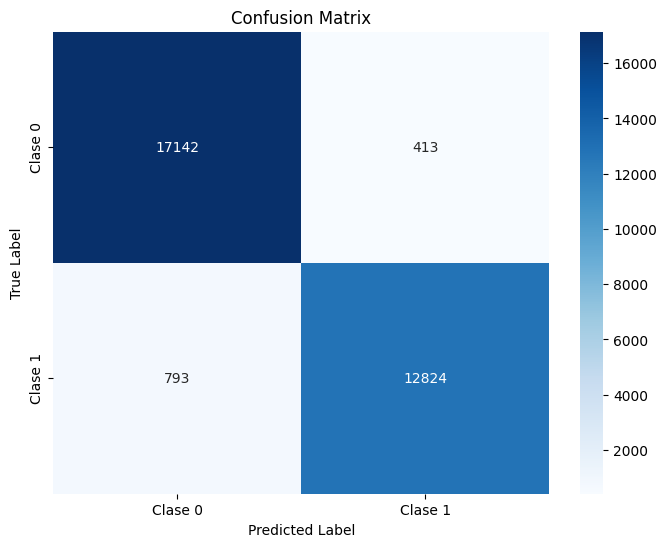

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     17555
           1       0.97      0.94      0.96     13617

    accuracy                           0.96     31172
   macro avg       0.96      0.96      0.96     31172
weighted avg       0.96      0.96      0.96     31172



In [3]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy}")
plt.show()
print("Reporte de clasificación:\n", class_report)

Cálculo de curva ROC para evaluación de rendimiento del modelo

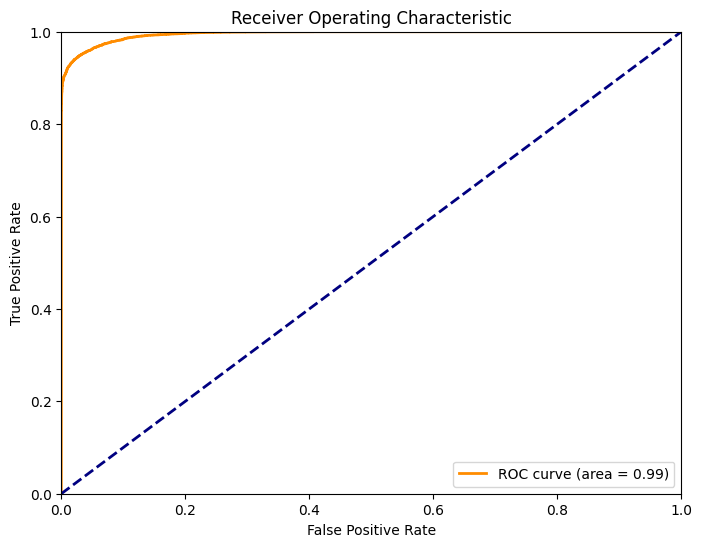

In [4]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Visualización de overfitting

Training Accuracy: 0.9777951933124347
Test Accuracy: 0.9613114333376107


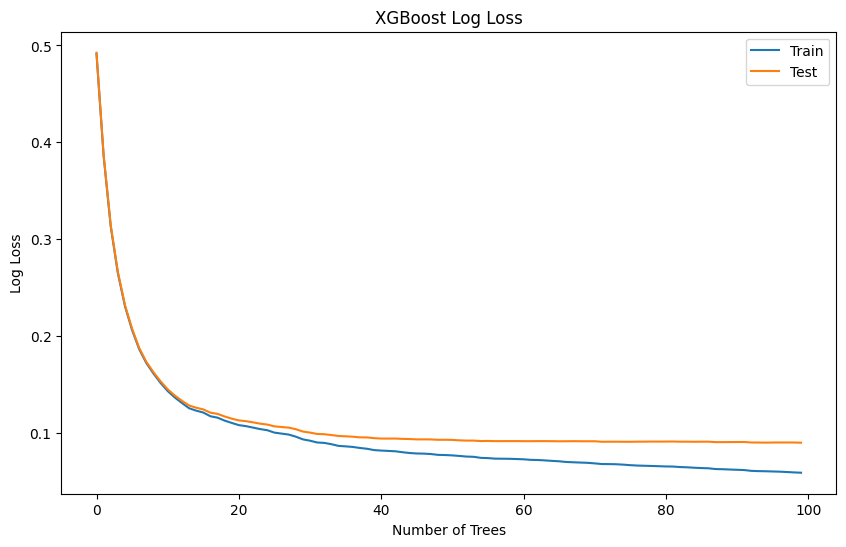

El modelo parece tener un buen ajuste.


In [5]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.legend(loc='upper right')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

if train_accuracy > test_accuracy + 0.05:  # Fijamos un 5% que es lo solicitado en el briefing
    print("El modelo podría estar sobreajustado (overfitting).")
else:
    print("El modelo parece tener un buen ajuste.")

### Pruebas con nuevos datos

Generamos una base de datos aleatoria

In [6]:
import random

def generar_valores_aleatorios():
    return {
        'Gender': random.randint(0, 1),
        'Customer Type': random.randint(0, 1),
        'Age': random.randint(0, 100),
        'Type of Travel': random.randint(0, 1),
        'Class': random.randint(0, 2),
        'Flight Distance': random.randint(0, 10000),
        'Inflight wifi service': random.randint(0, 6),
        'Departure/Arrival time convenient': random.randint(0, 6),
        'Ease of Online booking': random.randint(0, 6),
        'Gate location': random.randint(0, 6),
        'Food and drink': random.randint(0, 6),
        'Online boarding': random.randint(0, 6),
        'Seat comfort': random.randint(0, 6),
        'Inflight entertainment': random.randint(0, 6),
        'On-board service': random.randint(0, 6),
        'Leg room service': random.randint(0, 6),
        'Baggage handling': random.randint(0, 6),
        'Checkin service': random.randint(0, 6),
        'Inflight service': random.randint(0, 6),
        'Cleanliness': random.randint(0, 6),
        'Departure Delay in Minutes': random.randint(0, 2000),
        'Arrival Delay in Minutes': random.randint(0, 2000)
    }

# Base de datos
num_filas = 10000
datos = [generar_valores_aleatorios() for _ in range(num_filas)]

df = pd.DataFrame(datos)

print(df.head())

   Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0       0              1   94               1      2             9016   
1       0              0   99               0      0             1003   
2       1              1   39               1      2             9034   
3       1              1   55               0      2             5693   
4       1              0   90               0      1             6032   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      5                                  6   
1                      0                                  3   
2                      2                                  4   
3                      6                                  6   
4                      2                                  6   

   Ease of Online booking  Gate location  ...  Seat comfort  \
0                       2              4  ...             0   
1                       5              5  ...           

In [1]:
prediccion = model.predict(df)
predicted_probability = model.predict_proba(df)[:, 1]

df['Prediccion'] = prediccion
df['Predicted_Probability'] = round(predicted_probability, 2)

print(df.head())
df.to_csv('../Data/XGBoost_predicciones.csv', index=False)

NameError: name 'model' is not defined

Selección de Hyperparametros con hyperopt

In [9]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf = xgb.XGBClassifier(
        n_estimators=space['n_estimators'],
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],  # float entre 0 y 1
        eval_metric='logloss'  # Desde el constructor
    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    print("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                 
0.948190683947132                                      
SCORE:                                                                           
0.9470678814320544                                                               
SCORE:                                                                           
0.9480302835878353                                                               
SCORE:                                                                           
0.9426729115873219                                                               
SCORE:                                                                           
0.9440523546772744                                                               
SCORE:                                                                           
0.9452072372642115                                                               
SCORE:                                                              

Puntajes de validación cruzada: [0.95928974 0.95948222 0.95808671 0.95948222 0.95976901]
Media de los puntajes: 0.9592219793947228
Precisión del modelo: 0.9602207108943924


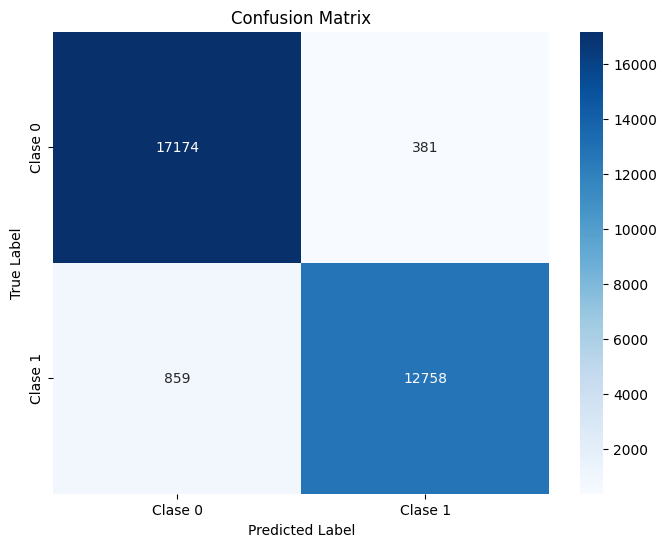

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     17555
           1       0.97      0.94      0.95     13617

    accuracy                           0.96     31172
   macro avg       0.96      0.96      0.96     31172
weighted avg       0.96      0.96      0.96     31172



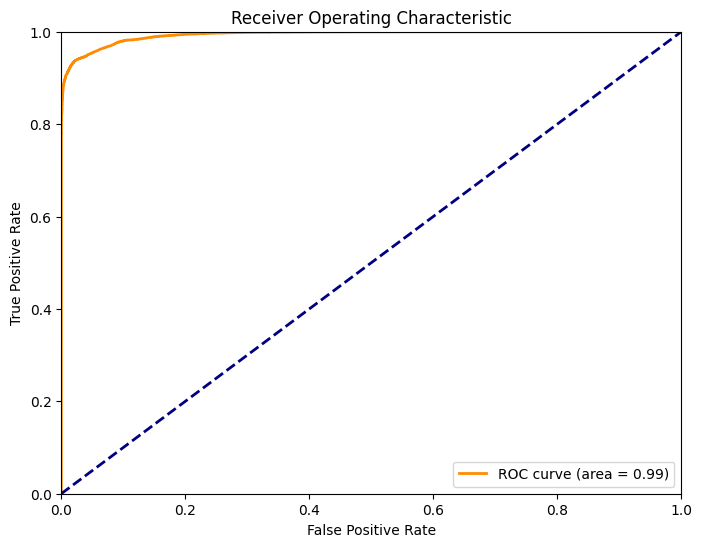

Training Accuracy: 0.9604713193642413
Test Accuracy: 0.9602207108943924


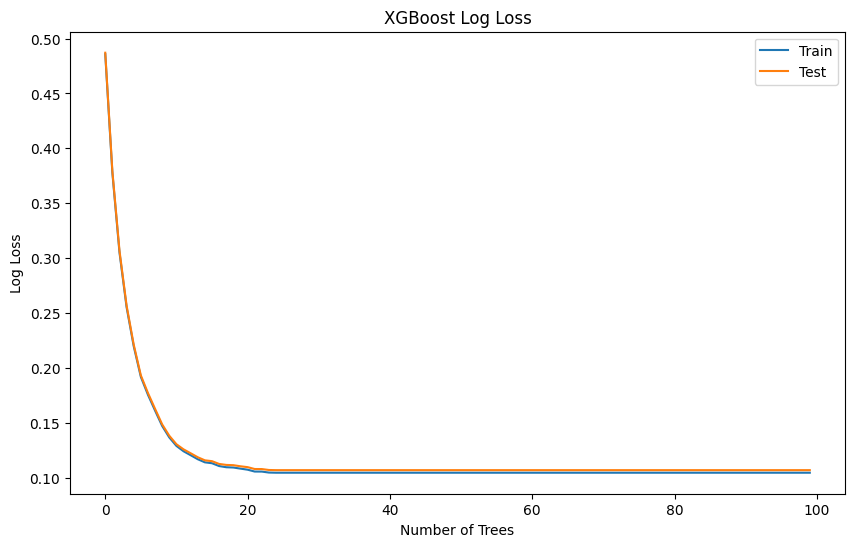

El modelo parece tener un buen ajuste.


In [ ]:
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

airline_df = pd.read_csv('../Data/airline_recoded.csv')

X = airline_df.drop(columns = ['satisfaction'])
y = airline_df['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

eval_set = [(X_train, y_train), (X_test, y_test)]
model = xgb.XGBClassifier(
    max_depth=int(best_hyperparams['max_depth']),
    gamma=best_hyperparams['gamma'],
    reg_alpha=int(best_hyperparams['reg_alpha']),
    min_child_weight=int(best_hyperparams['min_child_weight']),
    colsample_bytree=best_hyperparams['colsample_bytree'],
    eval_metric='logloss'  
)

model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

results = model.evals_result()

y_pred = model.predict(X_test)

cv_scores = cross_val_score(model, X, y, cv=5)

print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

train_accuracy = model.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.legend(loc='upper right')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

if train_accuracy > test_accuracy + 0.05:  # Fijamos un 5% que es lo solicitado en el briefing
    print("El modelo podría estar sobreajustado (overfitting).")
else:
    print("El modelo parece tener un buen ajuste.")